### Content:
- Load stock prices for all companies (or industry-wise)
- Calculate rejection rate for cointegration (null hypothesis: no cointegration)
- Inspect pairs with high rejection rate (low p-value)  [Collect examples]
- Look for great jumps in data

In [61]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import itertools

sys.path.append("..") # Adds higher directory to python modules path for importing from src dir
from src.datasets import NyseStocksDataset, NyseSecuritiesDataset
import src.econometric_utils as eco_utils
import src.math_utils as math_utils
# from statsmodels.tsa.stattools import grangercausalitytests

%matplotlib inline
%load_ext autotime
%load_ext autoreload
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 32 ms


In [11]:
stocks = NyseStocksDataset('OCMvOC-3C', file_path='../data/nyse/prices-split-adjusted.csv', features=['open', 'close', 'movement', 'vix_open', 'vix_close'], load=True)
securities = NyseSecuritiesDataset(file_path='../data/nyse/securities.csv', load=True)

gspc = stocks.load_gspc().gspc_open.reset_index(drop=True)
gspc_r = eco_utils.get_daily_rel_change(gspc)


time: 14.4 s


Approximate entropy (ApEn) and auto mutual information (AMI). ApEn quantifies regularity in data, while AMI detects linear and nonlinear dependencies in time series
<https://www.ncbi.nlm.nih.gov/pubmed/18784948>

In [32]:
prices = stocks.get_all_prices()
companies = sorted(prices.symbol.unique())

# Determine most occurring shape
shapes = []
grouped = prices.groupby('symbol', sort=False)
for comp_symbol, comp_prices in grouped:
    shapes.append((comp_symbol, len(comp_prices)))    
med = np.median([int(x[1]) for x in shapes])

# Select only companies with exact shape (470 -> 467 companies)

symbols = [x[0] for x in shapes if x[1] == med]
prices = prices[prices['symbol'].isin(symbols)]
grouped = prices.groupby('symbol', sort=False)

abs_prices = {idx: grouped.get_group(idx).open.reset_index(drop=True) for idx in symbols}
rel_prices = {idx: eco_utils.get_daily_rel_change(p) for idx, p in abs_prices.items()}

time: 828 ms


### Supported measurements
- `math_utils.shan_entropy(X)`
- `math_utils.correlation(X, Y)`
- `math_utils.approximate_entropy(X)`
- `math_utils.calc_mi(X, Y)`
- `math_utils.cross_correlation(X, Y)`
- `math_utils.normalized_cross_correlation(X, Y)`
- `math_utils.auto_correlation(X, lag=5)`
- `eco_utils.get_best_cointegration_certainty(X, Y)`
- `eco_utils.get_granger_causality(X, Y, lag=5)`

In [13]:
measures_1 = {
    'entropy': math_utils.shan_entropy,
    'ts_entropy': math_utils.approximate_entropy,
    'auto_corr1': lambda X: math_utils.auto_correlation(X, lag=1)[0],
    'auto_corr5': lambda X: math_utils.auto_correlation(X, lag=5)[0],
    'auto_corr25': lambda X: math_utils.auto_correlation(X, lag=25)[0],
    'auto_mi1': lambda X: math_utils.auto_mutual_information(X, lag=1)[0],
    'auto_mi5': lambda X: math_utils.auto_mutual_information(X, lag=5)[0],
    'auto_mi25': lambda X: math_utils.auto_mutual_information(X, lag=25)[0],
}

# Cointegration and Granger Cause are not bidirectional
measures_2 = {
    'pearson_r': math_utils.correlation,
#     'cross_corr': math_utils.cross_correlation,
    'cross_corr': math_utils.normalized_cross_correlation,
    'mi': math_utils.mutual_information,
    'norm_mi1': lambda X, Y: math_utils.mutual_information(X, Y, normalized=True),
    'norm_mi2': math_utils.normalized_mutual_information,
    'coint': eco_utils.get_best_cointegration_certainty,
    'granger_caus1': lambda X, Y: eco_utils.get_granger_causality(X, Y, lag=1)[0],
    'granger_caus5': lambda X, Y: eco_utils.get_granger_causality(X, Y, lag=5)[0],
    'granger_caus25': lambda X, Y: eco_utils.get_granger_causality(X, Y, lag=25)[0],
}

def get_unary_measures(X):
    values = {}
    for measure_name in measures_1:
        values[measure_name] = measures_1[measure_name](X)
    return values

def get_binary_measures(X, Y):
    values = {}
    for measure_name in measures_2:
        values[measure_name] = measures_2[measure_name](X, Y)
    return values

time: 25.3 ms


In [14]:
apple_stock = stocks.get_prices('AAPL').open.reset_index(drop=True)
rel_apple_stock = eco_utils.get_daily_rel_change(apple_stock)
microsoft_stock = stocks.get_prices('MSFT').open.reset_index(drop=True)
rel_microsoft_stock = eco_utils.get_daily_rel_change(microsoft_stock)

time: 64.8 ms


In [15]:
results = pd.DataFrame(0, index=['AAPL', 'AAPL_r', 'MSFT', 'MSFT_r'], columns=measures_1.keys())
results.loc['AAPL'] = pd.Series(get_unary_measures(apple_stock))
results.loc['AAPL_r'] = pd.Series(get_unary_measures(rel_apple_stock))
results.loc['MSFT'] = pd.Series(get_unary_measures(microsoft_stock))
results.loc['MSFT_r'] = pd.Series(get_unary_measures(rel_microsoft_stock))

results

,entropy,ts_entropy,auto_corr1,auto_corr5,auto_corr25,auto_mi1,auto_mi5,auto_mi25
AAPL,9.472396,0.002049,0.998316,0.993124,0.960890,3.960705,3.374458,3.124874
AAPL_r,5.296628,0.052303,-0.121483,-0.001213,-0.030395,1.061650,1.095391,1.112686
MSFT,9.553267,0.004603,0.988286,0.935559,0.707949,3.213961,2.608766,2.325970
MSFT_r,1.579984,0.053763,0.065858,-0.008878,-0.034322,1.092676,1.110726,1.090193


time: 986 ms


In [16]:
results2 = pd.DataFrame(0, index=pd.MultiIndex.from_tuples([['AAPL', 'MSFT'], ['AAPL_r', 'MSFT_r'], ['MSFT', 'AAPL']]), columns=measures_2.keys())
results2.loc[('AAPL', 'MSFT')] = pd.Series(get_binary_measures(apple_stock, microsoft_stock))
results2.loc[('AAPL_r', 'MSFT_r')] = pd.Series(get_binary_measures(rel_apple_stock, rel_microsoft_stock))
results2.loc[('MSFT', 'AAPL')] = pd.Series(get_binary_measures(microsoft_stock, apple_stock))

results2

,,pearson_r,cross_corr,mi,norm_mi1,norm_mi2,coint,granger_caus1,granger_caus5,granger_caus25
AAPL,MSFT,0.542443,0.542443,2.498549,0.281777,0.996616,4.532150e-01,0.295443,0.102236,0.312713
AAPL_r,MSFT_r,0.435575,0.435575,1.204630,0.139924,0.954001,1.288397e-21,0.184875,0.087138,0.488412
MSFT,AAPL,0.542443,0.542443,2.498549,0.281777,0.996616,9.352948e-02,0.300626,0.264006,0.394167


time: 1.27 s


In [ ]:
binary_features = pd.DataFrame(0.0, index=pd.MultiIndex.from_product([symbols, symbols]), columns=measures_2.keys())
for idx in tqdm(binary_features.index):
    if idx[0] >= idx[1]:
        continue
    p1 = rel_prices[idx[0]]  # abs_prices[idx[0]]
    p2 = rel_prices[idx[1]]  # abs_prices[idx[1]]
    binary_features.loc[idx] = pd.Series(get_binary_measures(p1, p2))
    binary_features.loc[(idx[1], idx[0])] = binary_features.loc[idx]

In [ ]:
# On relative price movements
# binary_features.to_csv('binary_features_rel.csv')
# On absolute price values
# binary_features.to_csv('binary_features_abs.csv')

In [40]:
unary_features = pd.DataFrame(0.0, index=symbols, columns=measures_1.keys())
for idx in tqdm(unary_features.index):
    unary_features.loc[idx] = pd.Series(get_unary_measures(abs_prices[idx]))  # rel_prices[idx]


time: 3min 12s


In [ ]:
# On relative price movements
# unary_features.to_csv('unary_features_rel.csv')
# On absolute price values
# unary_features.to_csv('unary_features_abs.csv')

### Correlation Matrix of Features

In [168]:
def plot_heatmap(df, figsize=(12, 10)):
    features = df.columns
    n = len(features)
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(df, cmap=plt.get_cmap('YlOrRd'), vmin=-1, vmax=1)
    plt.colorbar(im)

    # Rotate the tick labels and set their alignment.
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(features)
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
    
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(features)
    # plt.setp(ax.get_yticklabels(), rotation=45, ha='right', rotation_mode='anchor')

    # Loop over data dimensions and create text annotations.
    for i, j in itertools.product(range(n), range(n)):
            ax.text(i, j, f'{df.iloc[j, i]:.2f}', ha='center', va='center', color='w',
                    path_effects=[path_effects.withSimplePatchShadow(
                        offset=(1, -1), shadow_rgbFace='b', alpha=0.9)])

    ax.set_title('AUROC over all datasets and detectors')
    fig.tight_layout()
    return fig

time: 24 ms


### Unary features

In [163]:
rel_unary_features = pd.read_csv('unary_features_rel.csv', index_col=0)
abs_unary_features = pd.read_csv('unary_features_abs.csv', index_col=0)
occs = pd.read_csv('../data/preprocessed/occurrences/occurrences.csv', index_col=0)
occ_counts = pd.DataFrame(occs.groupby('stock_symbol').size(), columns=['occ'])
features = pd.concat([rel_unary_features, abs_unary_features.add_prefix('abs_')], axis=1)
features = features.join(occ_counts).fillna(0)

time: 424 ms


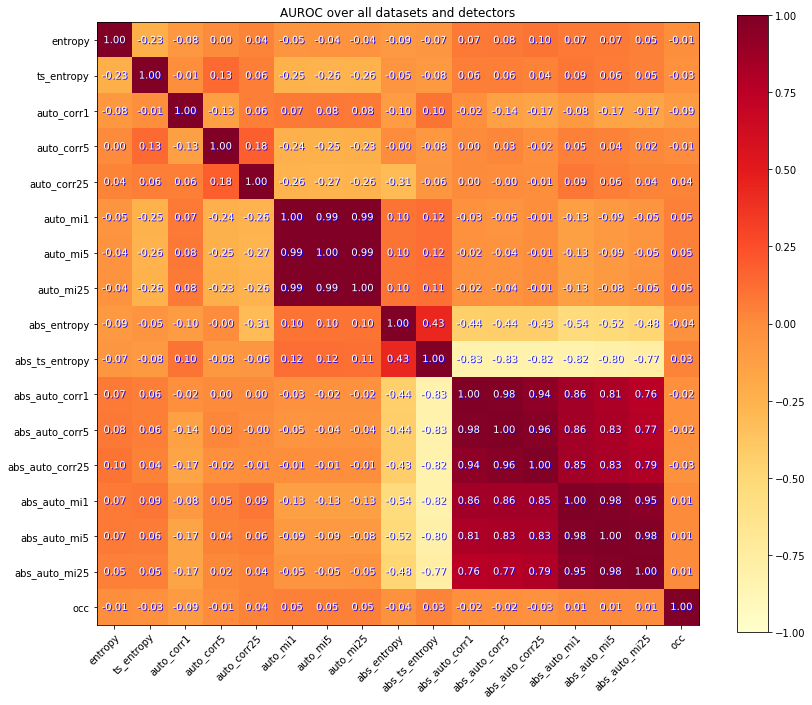

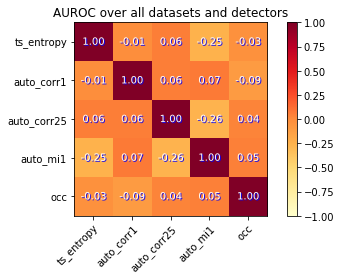

time: 4.06 s


In [172]:
fig = plot_heatmap(features.corr())
fig.savefig('corr-all-unary-features.pdf')
fig = plot_heatmap(features[['ts_entropy', 'auto_corr1', 'auto_corr25', 'auto_mi1', 'occ']].corr(), figsize=(6, 4))
fig.savefig('corr-unary-features.pdf')

### Binary features

In [173]:
rel_binary_features = pd.read_csv('binary_features_rel.csv', index_col=(0, 1))
abs_binary_features = pd.read_csv('binary_features_abs.csv', index_col=(0, 1))
coocs = pd.read_csv('../data/preprocessed/occurrences/cooccurrences.csv', index_col=0).stack().astype(float)
features = pd.concat([rel_binary_features, abs_binary_features.add_prefix('abs_')], axis=1)
features = features.join(pd.Series(coocs, name='coocs')).fillna(0)

time: 2.24 s


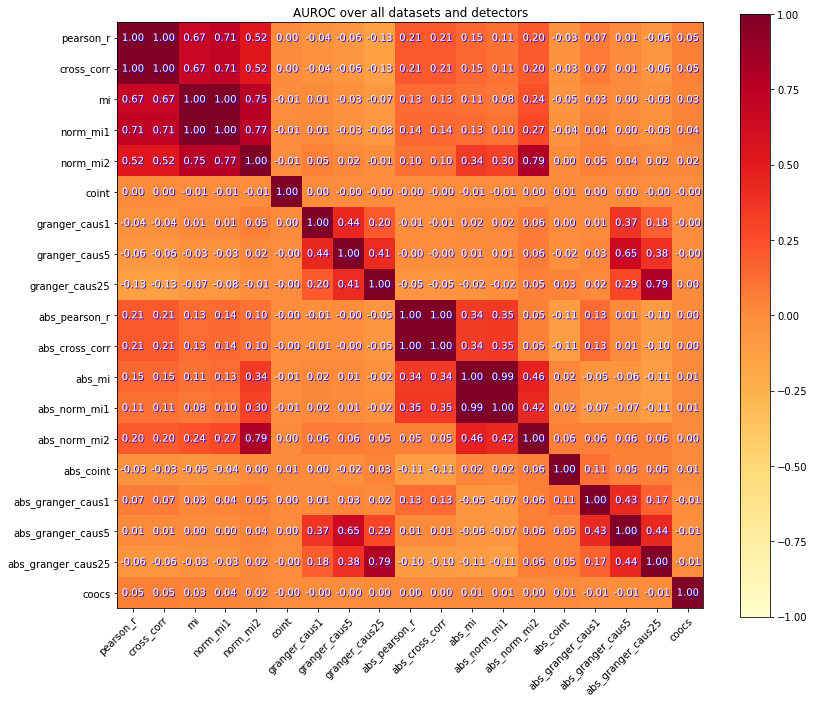

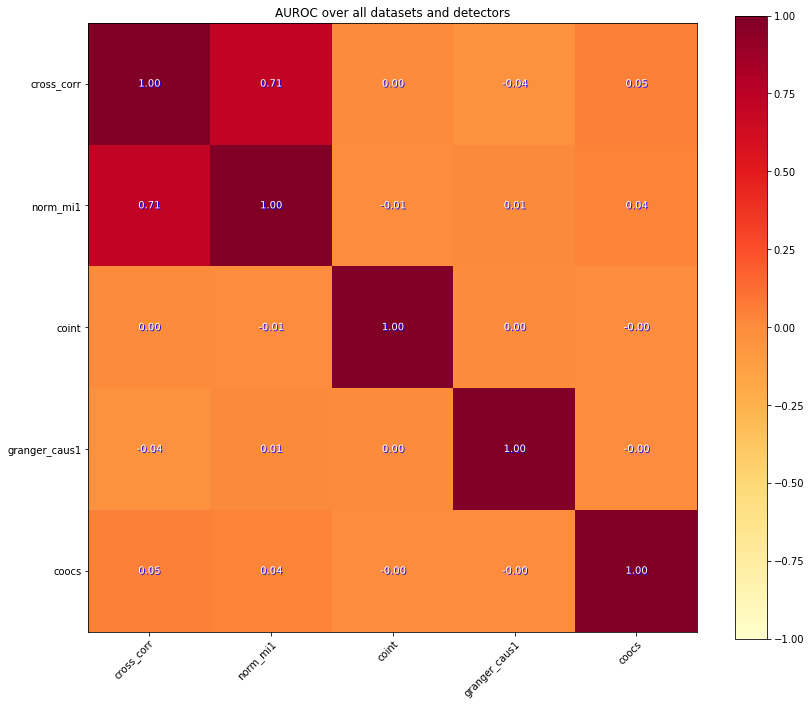

time: 5.55 s


In [174]:
fig = plot_heatmap(features.corr())
fig.savefig('corr-all-binary-features.pdf')
fig = plot_heatmap(features[['cross_corr', 'norm_mi1', 'coint', 'granger_caus1', 'coocs']].corr())
fig.savefig('corr-binary-features.pdf')

### From other notebook

# Show auto-correlation of stock prices

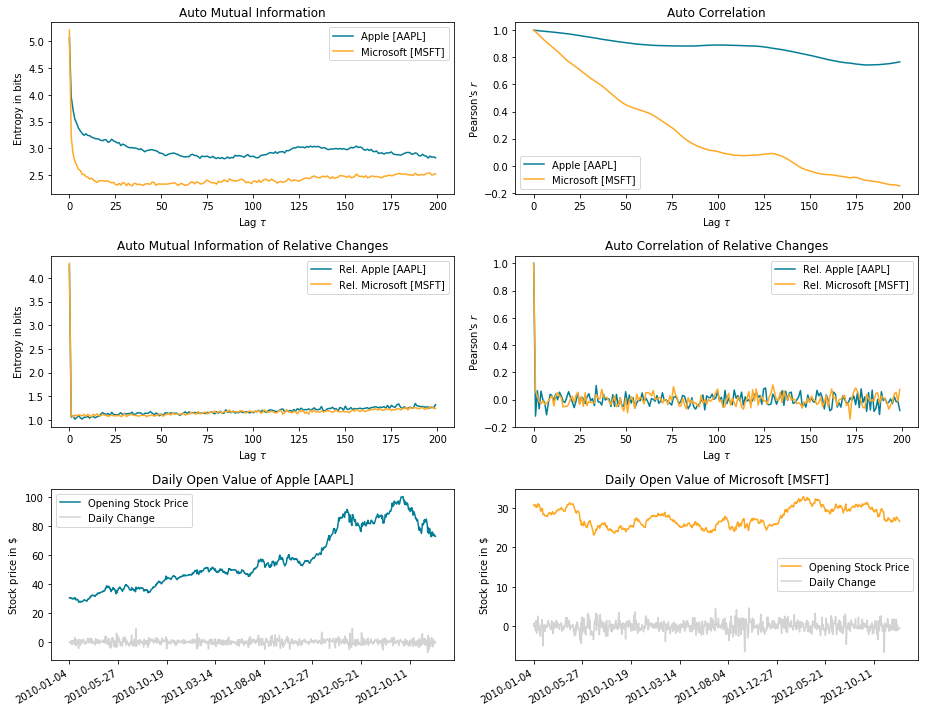

time: 4.94 s


In [174]:
colors = ['#037d95', '#ffa823']
fig, axes = plt.subplots(3, 2, figsize=(13, 10))

dates = stocks.get_prices('AAPL').date
apple_stock = stocks.get_prices('AAPL').open.reset_index(drop=True)
rel_apple_stock = eco_utils.get_daily_rel_change(apple_stock)
microsoft_stock = stocks.get_prices('MSFT').open.reset_index(drop=True)
rel_microsoft_stock = eco_utils.get_daily_rel_change(microsoft_stock)

axes[0, 0].plot(math_utils.auto_mutual_information(apple_stock, lag=200), label='Apple [AAPL]', color=colors[0])
axes[0, 0].plot(math_utils.auto_mutual_information(microsoft_stock, lag=200), label='Microsoft [MSFT]', color=colors[1])
axes[0, 0].set_title('Auto Mutual Information')
axes[0, 0].set_xlabel(r'Lag $\tau$')
axes[0, 0].set_ylabel(r'Entropy in bits')
axes[0, 0].legend()

axes[0, 1].plot(math_utils.auto_correlation(apple_stock, lag=200), label='Apple [AAPL]', color=colors[0])
axes[0, 1].plot(math_utils.auto_correlation(microsoft_stock, lag=200), label='Microsoft [MSFT]', color=colors[1])
axes[0, 1].set_title('Auto Correlation')
axes[0, 1].set_xlabel(r'Lag $\tau$')
axes[0, 1].set_ylabel('Pearson\'s $r$')
axes[0, 1].legend()

axes[1, 0].plot(math_utils.auto_mutual_information(rel_apple_stock, lag=200), label='Rel. Apple [AAPL]', color=colors[0])
axes[1, 0].plot(math_utils.auto_mutual_information(rel_microsoft_stock, lag=200), label='Rel. Microsoft [MSFT]', color=colors[1])
axes[1, 0].set_title('Auto Mutual Information of Relative Changes')
axes[1, 0].set_xlabel(r'Lag $\tau$')
axes[1, 0].set_ylabel(r'Entropy in bits')
axes[1, 0].legend()

axes[1, 1].plot(math_utils.auto_correlation(rel_apple_stock, lag=200), label='Rel. Apple [AAPL]', color=colors[0])
axes[1, 1].plot(math_utils.auto_correlation(rel_microsoft_stock, lag=200), label='Rel. Microsoft [MSFT]', color=colors[1])
axes[1, 1].set_title('Auto Correlation of Relative Changes')
axes[1, 1].set_xlabel(r'Lag $\tau$')
axes[1, 1].set_ylabel('Pearson\'s $r$')
axes[1, 1].legend()

axes[2, 0].plot(apple_stock, color=colors[0], label='Opening Stock Price')
axes[2, 0].plot(rel_apple_stock * 100, 'lightgray', label='Daily Change')
axes[2, 0].set_title('Daily Open Value of Apple [AAPL]')
xticklabels = np.concatenate([[''], dates.iloc[axes[2, 0].get_xticks()[1:-1].astype(int)].astype(str), ['']])
axes[2, 0].set_xticklabels(xticklabels)
plt.setp(axes[2, 0].get_xticklabels(), rotation=30, ha='right')
axes[2, 0].set_ylabel('Stock price in $\$$')
axes[2, 0].legend()

axes[2, 1].plot(microsoft_stock, color=colors[1], label='Opening Stock Price')
axes[2, 1].plot(rel_microsoft_stock * 100, 'lightgray', label='Daily Change')
axes[2, 1].set_title('Daily Open Value of Microsoft [MSFT]')
xticklabels = np.concatenate([[''], dates.iloc[axes[2, 1].get_xticks()[1:-1].astype(int)].astype(str), ['']])
axes[2, 1].set_xticklabels(xticklabels)
plt.setp(axes[2, 1].get_xticklabels(), rotation=30, ha='right')
axes[2, 1].set_ylabel('Stock price in $\$$')
axes[2, 1].legend()

fig.tight_layout()
fig.savefig('auto-measurements-aapl-msft.pdf')

In [669]:
# Source: http://www.gardening.cornell.edu/homegardening/scene638f.html
color = ['lightgray', '#037d95', '#ffa823']  # lightgrey, blue green, orange yellow
# features = pd.read_csv('cointegration.csv', index_col=0)


def inspect_pair(pair, value, normalize_price=False):
    value = features.loc[pair[0], pair[1]] if value is None else value
    companies = [securities.get_company_name(x) for x in pair]
    if normalize_price:
        opens = [pd.Series(normalize(prices[x].open.reset_index(drop=True), gspc_r)) for x in pair]
    else:
        opens = [prices[x].open.reset_index(drop=True) for x in pair]
    pair_prices = pd.concat([gspc * np.max(opens) / gspc.max(), *opens], axis=1)
    pair_prices.columns = ['Scaled S&P 500'] + pair
    ax = pair_prices.plot(title=f'{companies[0]} [{pair[0]}] - {companies[1]} [{pair[1]}], Likelihood={value:.4f} %', color=color)
    xticklabels = np.concatenate([[''], prices[pair[0]].date.iloc[ax.get_xticks()[1:-1].astype(int)].astype(str), ['']])
    ax.set_xticklabels(xticklabels)
    ax.get_figure().autofmt_xdate()

time: 233 ms


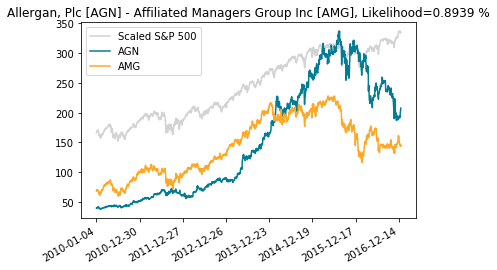

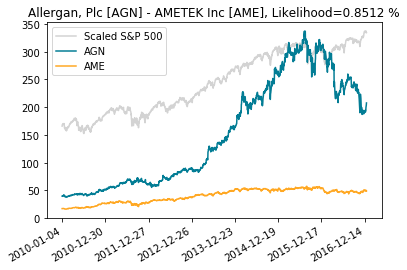

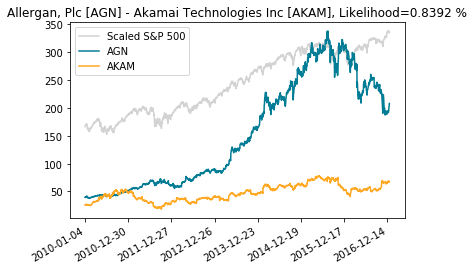

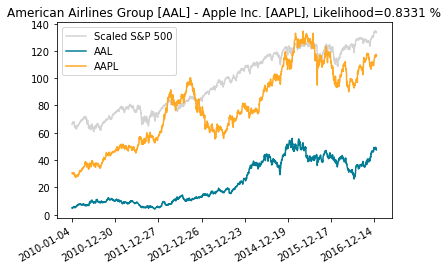

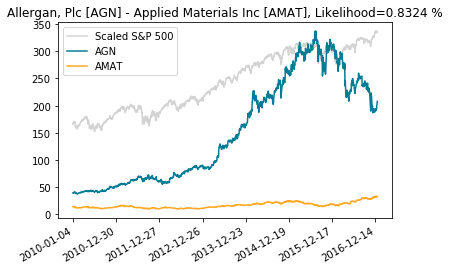

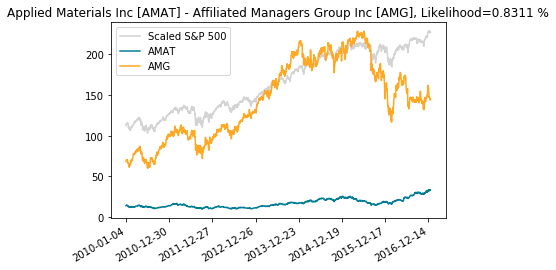

time: 2.42 s


In [588]:
amount = 30
stack = features.iloc[:amount, :amount].stack()
stack = stack[[p[0] < p[1] for p, v in stack.iteritems()]]
# stack = stack[[securities.get_industry(p[0]) == securities.get_industry(p[1]) for p, v in stack.iteritems()]]
for pair, value in stack.nlargest(6).iteritems():
    inspect_pair(list(pair), value)

### Correlating stock prices

In [598]:
features = pd.read_csv('cointegration-10-to-12.csv', index_col=0)
np.fill_diagonal(features.values, 0.5)

time: 425 ms


In [673]:
colors = ['#037d95', '#ffa823']  # blue green, orange yellow

def plot_company_price(symbols, ax=None):
    p = prices[symbols[0]]
    values = [prices[sym].open.reset_index(drop=True) for sym in symbols]
    values = pd.DataFrame(values).T
    values.columns = [securities.get_company_name(x) for x in symbols]
    ax = values.iloc[350:500].plot(ax=ax, color=colors[:len(symbols)], figsize=(5, 5))
    # ax = values.iloc[480:497].plot(color='#037d95')
    ax.set_xticks(ax.get_xticks()[2:-1:2])
    xticklabels = [p.date.iloc[x].date() if x in values.index else '' for x in ax.get_xticks().astype(int)]
    # xticklabels = np.concatenate([[''], [ax.get_xticks()[1:-1]], ['']])
    ax.set_xticklabels(xticklabels)
    ax.get_figure().autofmt_xdate()
    ax.get_figure().savefig('jpm-2011-12-27.pdf')
    return ax

time: 219 ms


In [626]:
def get_industry(sym) -> str:
    self = securities
    sec = self.data()
    return sec[sec['Ticker symbol'] == sym].iloc[0]['GICS Sector']
securities.get_industry = get_industry

time: 187 ms


In [627]:
stack = features.stack()
stack = stack[[p[0] < p[1] for p, v in stack.iteritems()]]
stack = stack[[securities.get_industry(p[0]) == securities.get_industry(p[1]) for p, v in stack.iteritems()]]
top = stack.nsmallest(20).reset_index()  # [['level_0', 'level_1']]
top = top.iloc[1:]

GOOG  GOOGL    0.000000e+00
AN    ORLY     4.632706e-07
LNT   XEL      2.723550e-06
BK    PFG      1.218435e-05
LEN   OMC      1.707725e-05
DOV   ROK      2.595259e-05
LNT   WEC      2.601267e-05
AVB   ESS      2.755974e-05
HBAN  IVZ      3.234923e-05
AMG   PFG      3.588369e-05
LNT   SRE      3.696372e-05
AMG   BK       3.884187e-05
AVB   EQIX     5.978959e-05
CME   ZION     6.148674e-05
AVB   UDR      6.692155e-05
AEE   SO       7.478467e-05
FDX   UNP      7.611358e-05
CME   SCHW     9.943116e-05
ACN   SYMC     1.574800e-04
BK    HIG      1.613608e-04
dtype: float64

time: 7min 31s


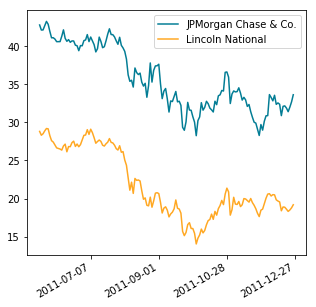

time: 832 ms


In [674]:
plot_company_price(['JPM', 'LNC'])
plt.gcf().savefig('jpm-lnc-2011-12-27.pdf')

Normalize by index


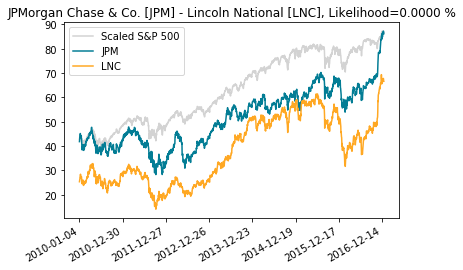

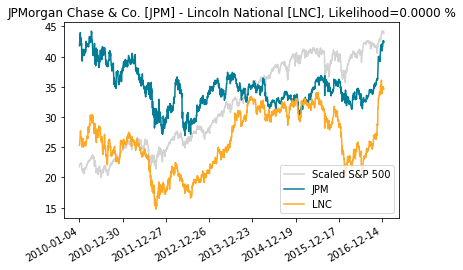

time: 960 ms


In [670]:
inspect_pair(['JPM', 'LNC'], 0)  # Financials
print("Normalize by index")
inspect_pair(['JPM', 'LNC'], 0, normalize_price=True)
# inspect_pair(['JPM', 'GS'])  # Bank
# inspect_pair(['AET', 'ANTM'])  # Health Insurance
# inspect_pair(['EMR', 'ETN'])  # Energy: https://www.fool.com/investing/general/2013/10/23/can-eaton-earnings-top-emerson-electric-and-abb.aspx

### Links Stack
- https://davegiles.blogspot.com/2011/04/testing-for-granger-causality.html
- http://cmi.comesa.int/wp-content/uploads/2014/06/Stationarity-and-Cointegration-Analysis.pdf
- https://stats.stackexchange.com/questions/328797/why-do-we-use-vector-autoregressive-models
- https://econometricswithr.wordpress.com/time-series/an-introduction-to-vector-autoregression-var/
- https://ideas.repec.org/a/taf/applec/v38y2006i13p1489-1500.html
- file:///C:/Users/Thomas/Documents/song2017%20-%20A%20better%20understanding%20of%20Granger%20causality%20analysis%20-%20a%20big%20data%20environment.pdf
- https://www.tandfonline.com/doi/abs/10.1080/00949650008811997?src=recsys
- https://www.researchgate.net/post/How_should_I_perform_2-step_co-integration_test_Should_I_input_the_original_data_for_regression_or_should_I_input_1st_order_difference